# Twitter author prediction

## Prerequisites

### Importing necessary libraries

In [157]:
import random; random.seed(53)
import pandas as pd

# Import all we need from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.pipeline import Pipeline
from pprint import pprint
from helper_functions import plot_confusion_matrix
import itertools


In [143]:
import matplotlib.pyplot as plt
import numpy as np
def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(ce)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.show()
    return top_coefficients

In [144]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



### Load the data

In [231]:
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets.csv")


Ez a másik adatbázis

In [289]:
# Vakhal
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets_1.csv")
#extract the texts and the authors where the author is either HillaryClinton or realDonaldTrump
tweet_df = tweet_df[tweet_df.is_retweet == False]
tweet_df = tweet_df[["handle", "text"]]
tweet_df.columns = ["author", "status"]


In [290]:
# Create target
y = tweet_df["author"]
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(tweet_df["status"], y, random_state=53, test_size=0.2)

## Data cleaning

### CountVectorizer

In [291]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)


### Tf-Idf

In [292]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training the models

### Training a multinomial naive Bayes model

In [293]:
# Create and fit the model for the tf-idf data
tf_idf_nb = MultinomialNB()
tf_idf_nb.fit(tfidf_train, y_train)
tf_idf_nb_pred = tf_idf_nb.predict(tfidf_test)

# Create and fit the model for the count data
count_nb = MultinomialNB()
count_nb.fit(count_train, y_train)
count_nb_pred = count_nb.predict(count_test)



### Training an SVM model

In [294]:
tf_idf_svc = LinearSVC(dual=False)
tf_idf_svc.fit(tfidf_train, y_train)
tf_idf_svc_pred = tf_idf_svc.predict(tfidf_test)



### Training a logistic regression model

In [295]:
from sklearn.linear_model import LogisticRegression
tf_idf_lr = LogisticRegression()
tf_idf_lr.fit(tfidf_train, y_train)
tf_idf_lr_pred = tf_idf_lr.predict(tfidf_test)



### Training a decision tree model

In [296]:
from sklearn.tree import DecisionTreeClassifier
tf_idf_dt = DecisionTreeClassifier()
tf_idf_dt.fit(tfidf_train, y_train)
tf_idf_dt_pred = tf_idf_dt.predict(tfidf_test)



### Training a random forest model

In [297]:
from sklearn.ensemble import RandomForestClassifier
tf_idf_rf = RandomForestClassifier(oob_score=True)
tf_idf_rf.fit(tfidf_train, y_train)
tf_idf_rf_pred = tf_idf_rf.predict(tfidf_test)

## Accuracy scores (for the tf-idf vectorizer)

In [298]:
target_values = list(tf_idf_lr.classes_)
target_values

['HillaryClinton', 'realDonaldTrump']

### Confusion matrices

In [299]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values, normalize='true')
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values, normalize='true')
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values, normalize='true')
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values, normalize='true')
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values, normalize='true')

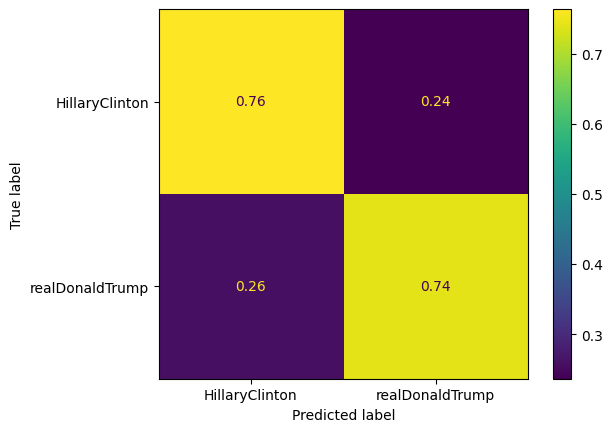

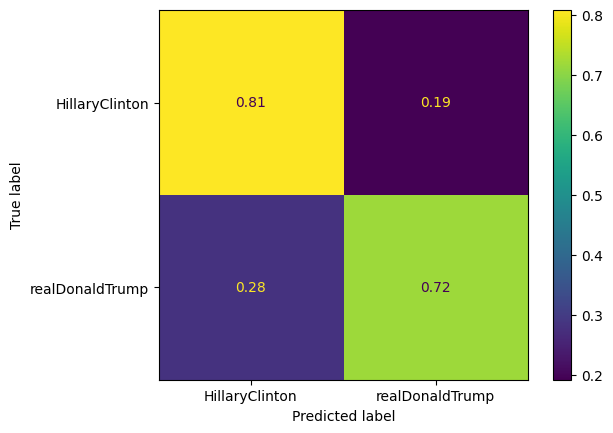

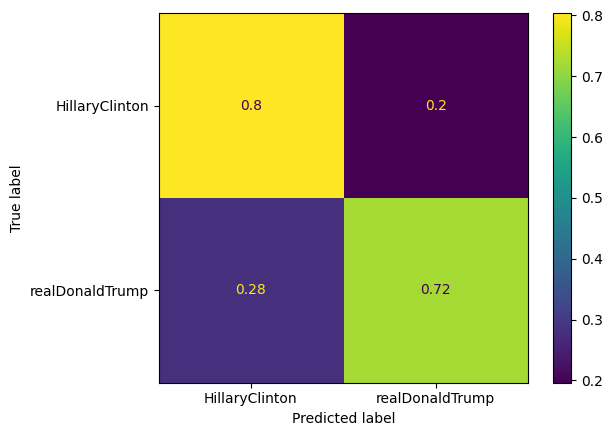

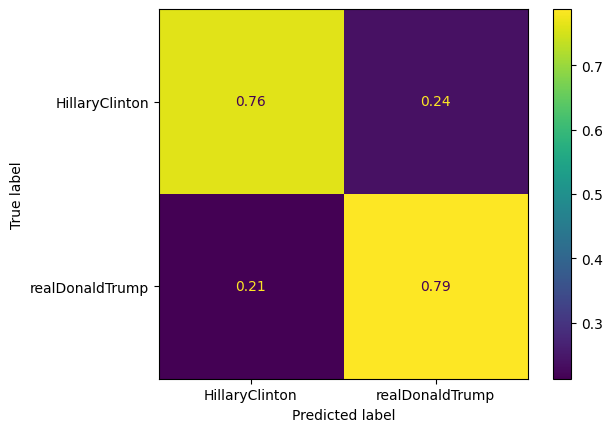

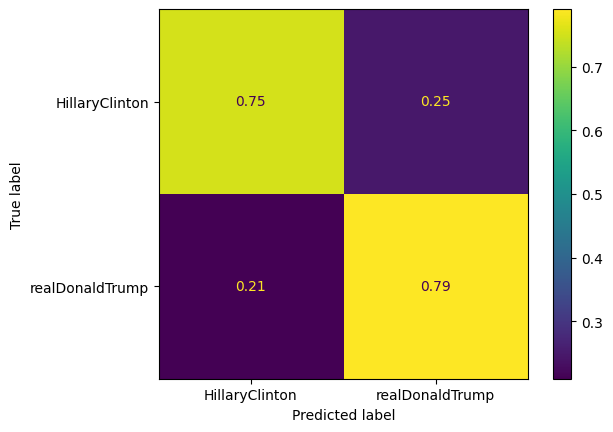

In [300]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()


### Accuracy scores of the models

In [301]:
print("Naive Bayes", tf_idf_nb.score(tfidf_test, y_test))
print("SVC", tf_idf_svc.score(tfidf_test, y_test))
print("Logistic Regression", tf_idf_lr.score(tfidf_test, y_test))
print("Decision Tree", tf_idf_dt.score(tfidf_test, y_test))
print("Random Forest", tf_idf_rf.score(tfidf_test, y_test))

Naive Bayes 0.7519650655021834
SVC 0.7589519650655022
Logistic Regression 0.7589519650655022
Decision Tree 0.7755458515283843
Random Forest 0.7737991266375546


### Recall scores of the models

In [302]:
print("Naive Bayes", metrics.recall_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC", metrics.recall_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression", metrics.recall_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree", metrics.recall_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest", metrics.recall_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes 0.7634615384615384
SVC 0.8076923076923077
Logistic Regression 0.8038461538461539
Decision Tree 0.7615384615384615
Random Forest 0.7538461538461538


### Precision scores of the models

In [303]:
print("Naive Bayes", metrics.precision_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC", metrics.precision_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression", metrics.precision_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree", metrics.precision_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest", metrics.precision_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))


Naive Bayes 0.7114695340501792
SVC 0.7046979865771812
Logistic Regression 0.706081081081081
Decision Tree 0.7485822306238186
Random Forest 0.7495219885277247


f1-scores of the models

In [304]:
print("Naive Bayes", metrics.f1_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC", metrics.f1_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression", metrics.f1_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree", metrics.f1_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest", metrics.f1_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))


Naive Bayes 0.7365491651205937
SVC 0.7526881720430108
Logistic Regression 0.7517985611510792
Decision Tree 0.7550047664442326
Random Forest 0.7516778523489933


### Roc-auc scores of the models

In [305]:
print("Naive Bayes", metrics.roc_auc_score(y_test, tf_idf_nb.predict_proba(tfidf_test)[:,1]))
print("SVC does not support predict_proba")
print("Logistic Regression", metrics.roc_auc_score(y_test, tf_idf_lr.predict_proba(tfidf_test)[:,1]))
print("Decision Tree", metrics.roc_auc_score(y_test, tf_idf_dt.predict_proba(tfidf_test)[:,1]))
print("Random Forest", metrics.roc_auc_score(y_test, tf_idf_rf.predict_proba(tfidf_test)[:,1]))

Naive Bayes 0.8063292307692308
SVC does not support predict_proba
Logistic Regression 0.8386061538461539
Decision Tree 0.8436492307692308
Random Forest 0.8526507692307694
